In [28]:
import pandas as pd
import numpy as np
import requests
import json
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
ds = pd.read_csv('../input/starbucks.csv', encoding="utf-8")

In [4]:
ds.shape

(25600, 13)

Hacemos scraping de countrycode.org para traernos el nombre del país a partir del codigo ISO del dataset

In [5]:
url_codes = 'https://countrycode.org/'
data_codes = requests.get(url_codes).text
soup_codes = BeautifulSoup(data_codes, 'html.parser')    

In [6]:
#[tag.find_all("th") for tag in soup_codes.find_all('table')][1]

In [7]:
def procesaFila(tag):
    m = tag.find_all("td")
    return {
        "pais":m[0].find("a").text.strip(),
        #"cod_n":m[1].text,
        "Country":m[2].text.split(' /')[0]
    }
    
table_codes = soup_codes.find_all('table')[1]
table_codes_clean = [procesaFila(fila) for fila in table_codes.find_all("tr")[1:]]

In [8]:
countries = pd.DataFrame(table_codes_clean)

Hacemos el merge de los dos dataframes

In [9]:
result = pd.merge(ds, countries, how='left', on=['Country', 'Country'])
result.head()

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude,pais
0,Starbucks,47370-257954,"Meritxell, 96",Licensed,"Av. Meritxell, 96",Andorra la Vella,7,AD,AD500,376818720,GMT+1:00 Europe/Andorra,1.53,42.51,Andorra
1,Starbucks,22331-212325,Ajman Drive Thru,Licensed,"1 Street 69, Al Jarf",Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.42,United Arab Emirates
2,Starbucks,47089-256771,Dana Mall,Licensed,Sheikh Khalifa Bin Zayed St.,Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.39,United Arab Emirates
3,Starbucks,22126-218024,Twofour 54,Licensed,Al Salam Street,Abu Dhabi,AZ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,54.38,24.48,United Arab Emirates
4,Starbucks,17127-178586,Al Ain Tower,Licensed,"Khaldiya Area, Abu Dhabi Island",Abu Dhabi,AZ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,54.54,24.51,United Arab Emirates


In [10]:
result = result.drop(['Ownership Type','State/Province','Country','Postcode','Phone Number','Timezone'], axis=1)

In [12]:
#result.columns

In [51]:
#grouped = result.groupby(['pais']).count()
#result.sort_values(['Store Number'],ascending=False).groupby('pais').head(10)
#result.groupby(["pais"])["Store Number"].nlargest(10)
#res = grouped.apply(lambda x: x.order(ascending=False).head(10))
#grouped.nlargest(10)
df_agg = result[result['pais']!='United States'].groupby(['pais']).agg('Store Name')
g = df_agg.groupby(level=0, group_keys=False).size().plot(kind='bar',figsize=(10,5))
plt.show()

AttributeError: Cannot access callable attribute 'groupby' of 'SeriesGroupBy' objects, try using the 'apply' method

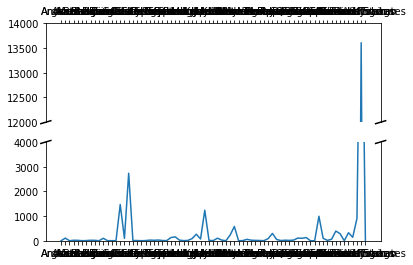

In [40]:
f, (ax, ax2) = plt.subplots(2, 1, sharex=True)

# plot the same data on both axes
ax.plot(result.groupby(['pais']).size())
ax2.plot(result.groupby(['pais']).size())

# zoom-in / limit the view to different portions of the data
ax.set_ylim(12000, 14000)  # outliers only
ax2.set_ylim(0, 4000)  # most of the data

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop='off')  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# This looks pretty good, and was fairly painless, but you can get that
# cut-out diagonal lines look with just a bit more work. The important
# thing to know here is that in axes coordinates, which are always
# between 0-1, spine endpoints are at these locations (0,0), (0,1),
# (1,0), and (1,1).  Thus, we just need to put the diagonals in the
# appropriate corners of each of our axes, and so long as we use the
# right transform and disable clipping.

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'

plt.show()

In [14]:
result.to_csv('../input/starbucks_updt.csv', index = None, header=True)